# Sea Ice Comparisons to Observations

This script shows how to load and plot sea ice concentration from CICE output .....

Run _SeaIce_ERA5_Intake_Cat.ipynb_ first

Requirements: The conda/analysis3 module from /g/data/hh5/public/modules. 

**ERA 5 Runs:**

In [1]:
RUNS={
    '025deg_era5':['025deg_era5_iaf'], #(our name: run name(s))
    '025deg_jra55': ['025deg_jra55_iaf_era5comparison'],
    '1deg_era5':['1deg_era5_iaf'],
    '1deg_jra55':['1deg_jra55_iaf_era5comparison']
}


In [2]:
VARS=['hi_m', 'hs_m', 'aice_m'] #ice thickness, snow thickness, ice area fraction
VARS_2D=['area_t','geolat_t','geolon_t']

**OBS Data:**

In [3]:
ST='1979'
ET='2022'
OBS_TIME_SLICE=slice(ST,ET)
sh_obs_url='https://polarwatch.noaa.gov/erddap/griddap/nsidcG02202v4shmday'
nh_obs_url='https://polarwatch.noaa.gov/erddap/griddap/nsidcG02202v4nhmday'
_obs_data_dir='/g/data/gv90/P6_data/'
#Using NSIDC, see below for dets

Climatology Time Slice:

n.b. The 1 degree runs only start in 1980, so i've picked a shorter 20 year climatology, rather than a more typical 1981-2010 or 1979-2008

In [4]:
CLIMAT_SLICE=slice('1991,2010')

Check conda/analysis version

In [5]:
! conda env list

# conda environments:
#
                         /g/data/gv90/as2285/miniconda3
                         /g/data/gv90/as2285/miniconda3/envs/sea-ice-extremes
                         /g/data/gv90/as2285/miniconda3/envs/sea-ice-plots
                         /g/data/gv90/as2285/miniconda3/envs/sea-ice-tracker
base                  *  /g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07
access-nri-intake-test     /scratch/tm70/as2285/conda/envs/access-nri-intake-test
nmltab                   /scratch/tm70/as2285/conda/envs/nmltab



Create a work directory:

In [6]:
_scratch_path = !echo /scratch/$PROJECT/$USER/

_work_path=_scratch_path[0]+'era5_datastore/'

In [7]:
cd {_work_path}

/scratch/tm70/as2285/era5_datastore


Load modules:

In [8]:
import intake

import matplotlib.pyplot as plt
from dask.distributed import Client
from datetime import timedelta
import cf_xarray as cfxr
import cartopy.crs as ccrs
import xarray as xr
import xesmf
import numpy as np
import cmocean.cm as cmo

from datatree import DataTree,map_over_subtree


Load the open_run function

In [9]:
_notebook_path= !echo /g/data/$PROJECT/$USER/

_notebook_path=_notebook_path[0]+'/cosima-recipes'

%run '{_notebook_path}/DocumentedExamples/CICE_Loaders.ipynb'

In [10]:
client = Client()

In [11]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 12,Total memory: 46.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41289,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 12
Started: Just now,Total memory: 46.00 GiB
Comm: tcp://127.0.0.1:39603,Total threads: 3
Dashboard: /proxy/38863/status,Memory: 11.50 GiB
Nanny: tcp://127.0.0.1:40843,


Open the catalog

In [12]:
catalog=intake.open_df_catalog(
    'metacatalog.csv', 
    columns_with_iterables=['model','realm','frequency', 'variable']
)

# Load the ERA5 runs

In [13]:
%%time

si_dt = DataTree.from_dict(dict([
    (iRun, open_by_run(iRun, VARS)) for iRun in RUNS.keys()
]))

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/intake_esm/cat.py:270: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(type)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/intake_esm/cat.py:270: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(type)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/intake_esm/cat.py:270: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(type)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/intake_esm/cat.py:270: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(type)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/intake_esm/cat.py:270: FutureWarning: DataFrame.applymap has been deprecated. Use D

CPU times: user 40.1 s, sys: 3.46 s, total: 43.5 s
Wall time: 4min 4s


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/intake_esm/cat.py:270: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(type)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/intake_esm/cat.py:270: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(type)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/intake_esm/cat.py:270: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(type)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/intake_esm/cat.py:270: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(type)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/intake_esm/cat.py:270: FutureWarning: DataFrame.applymap has been deprecated. Use D

In [14]:
@map_over_subtree
def match_timestamps_to_NSIDC(cice_ds):

    # we are going to use the same timestamps as NSIDC
    cice_ds['time'] = [np.datetime64(str(i)[0:7]+'-01T00:00:00.000000000') for i in cice_ds.time.values]

    return cice_ds

In [15]:
si_dt = match_timestamps_to_NSIDC(si_dt)

In [16]:
si_dt

DataTree('None', parent=None)
├── DataTree('025deg_era5')
│       Dimensions:   (time: 523, yt_ocean: 1080, xt_ocean: 1440)
│       Coordinates:
│         * time      (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2023-07-01
│         * xt_ocean  (xt_ocean) float64 -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
│         * yt_ocean  (yt_ocean) float64 -81.08 -80.97 -80.87 ... 89.74 89.84 89.95
│           geolat_t  (yt_ocean, xt_ocean) float32 ...
│           geolon_t  (yt_ocean, xt_ocean) float32 ...
│           area_t    (yt_ocean, xt_ocean) float32 ...
│       Data variables:
│           hi_m      (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
│           hs_m      (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
│           aice_m    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
│       Attributes: (12/16)
│           title:                                    sea ice model output for CICE
│           contents:                                 Diagnostic and Prognostic Varia...
│           source:                                   Los Alamos Sea Ice Model (CICE)...
│           time_period_freq:                         month_1
│           comment3:                                 seconds elapsed into model date...
│           conventions:                              CF-1.0
│           ...                                       ...
│           intake_esm_attrs:variable_long_name:      boundaries for time-averaging i...
│           intake_esm_attrs:variable_standard_name:  
│           intake_esm_attrs:variable_cell_methods:   time: mean,time: mean,time: mea...
│           intake_esm_attrs:file_id:                 iceh_XXXX_XX
│           intake_esm_attrs:_data_format_:           netcdf
│           intake_esm_dataset_key:                   iceh_XXXX_XX.1mon
├── DataTree('025deg_jra55')
│       Dimensions:   (time: 523, yt_ocean: 1080, xt_ocean: 1440)
│       Coordinates:
│         * time      (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2023-07-01
│         * xt_ocean  (xt_ocean) float64 -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
│         * yt_ocean  (yt_ocean) float64 -81.08 -80.97 -80.87 ... 89.74 89.84 89.95
│           geolat_t  (yt_ocean, xt_ocean) float32 ...
│           geolon_t  (yt_ocean, xt_ocean) float32 ...
│           area_t    (yt_ocean, xt_ocean) float32 ...
│       Data variables:
│           aice_m    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
│           hs_m      (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
│           hi_m      (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
│       Attributes: (12/16)
│           title:                                    sea ice model output for CICE
│           contents:                                 Diagnostic and Prognostic Varia...
│           source:                                   Los Alamos Sea Ice Model (CICE)...
│           time_period_freq:                         month_1
│           comment3:                                 seconds elapsed into model date...
│           conventions:                              CF-1.0
│           ...                                       ...
│           intake_esm_attrs:variable_long_name:      boundaries for time-averaging i...
│           intake_esm_attrs:variable_standard_name:  
│           intake_esm_attrs:variable_cell_methods:   time: mean,time: mean,time: mea...
│           intake_esm_attrs:file_id:                 iceh_XXXX_XX
│           intake_esm_attrs:_data_format_:           netcdf
│           intake_esm_dataset_key:                   iceh_XXXX_XX.1mon
├── DataTree('1deg_era5')
│       Dimensions:   (time: 708, yt_ocean: 300, xt_ocean: 360)
│       Coordinates:
│         * time      (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2018-12-01
│         * x

# Lets open the obs dataset too

In [17]:
def open_cdr_dataset(path, area_file):
    ds=xr.open_dataset(path).rename(
        {'cdr_seaice_conc_monthly':'cdr_seaice_conc','xgrid':'x','ygrid':'y'}
    ) #.swap_dims({'tdim':'time','x':'xgrid','y':'ygrid'})

    datFile=open(area_file, 'rb')
    #pss25area_v3.dat: 316 columns x 332 rows
    areasDmNd=np.fromfile(datFile, dtype=np.int32).reshape(ds.cdr_seaice_conc.isel(time=0).shape)
    
    #Divide by 1000 to get km2
    areasKmNd_sh=areasDmNd/1000

    ds['area']=xr.DataArray(areasKmNd_sh, dims=['y','x'])
    ds=ds.set_coords('area')

    ds=ds.cdr_seaice_conc
    
    ds=ds.where(ds<=1)

    return ds

In [18]:
sh_cdr_xr = open_cdr_dataset(
    sh_obs_url,
    f'{_obs_data_dir}/NSIDC/pss25area_v3.dat'
)

In [19]:
nh_cdr_xr = open_cdr_dataset(
    nh_obs_url,
    f'{_obs_data_dir}/NSIDC/psn25area_v3.dat'
)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'melt_onset_day_cdr_seaice_conc_monthly' has multiple fill values {-1, 255}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


In [20]:
cdr_dt = DataTree.from_dict({
    'cdr_sh':sh_cdr_xr,
    'cdr_nh':nh_cdr_xr
})

# Calculate sea-ice area

In [21]:
def sea_ice_area(sic,area, range=[0.15,1]):
    return (sic*area).where((sic>=range[0])*(sic<=range[1])).cf.sum(['X','Y'])

In [22]:
@map_over_subtree
def sea_ice_area_obs(ds, range=[0.15,1]):
    sic=ds.cdr_seaice_conc
    result=sea_ice_area(sic,sic.area,range).to_dataset(name='cdr_area')

    #Theres a couple of data gaps which should be nan
    
    result.loc[{'time':'1988-01-01'}]=np.nan
    
    result.loc[{'time':'1987-12'}]=np.nan

    return result.sel(time=OBS_TIME_SLICE)

In [23]:
hist_area_dt=sea_ice_area_obs(cdr_dt)

In [24]:
hist_area_dt['cdr_nh'].to_dataset().loc[{'time':'1984-07'}]=np.nan

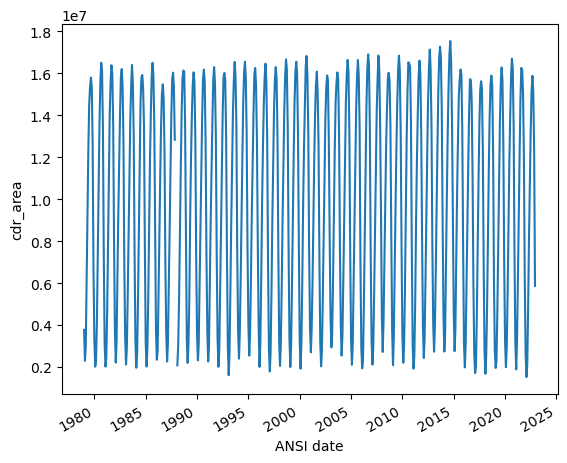

In [25]:
hist_area_dt['cdr_sh'].ds.cdr_area.plot()

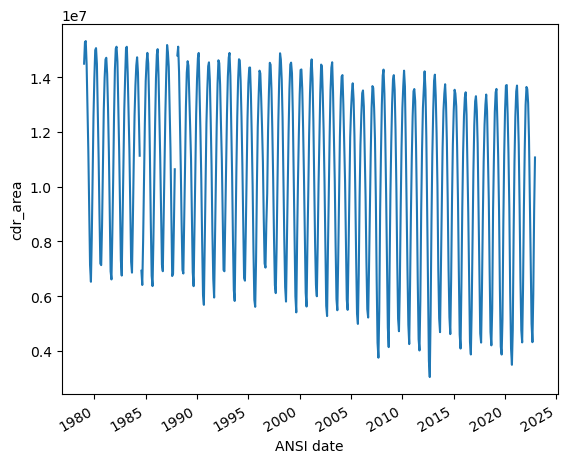

In [26]:
hist_area_dt['cdr_nh'].ds.cdr_area.plot()

# Sea Ice Area trends

In [27]:
@map_over_subtree
def calc_sh_area(ds):
    sic=ds.aice_m.cf.sel(Y=slice(-90,0))   
    area_km2=ds.area_t/1e6

    return sea_ice_area(sic,area_km2).to_dataset(name='si_area').load()

In [28]:
si_area_dt=calc_sh_area(si_dt)

In [29]:
si_area_dt

DataTree('None', parent=None)
├── DataTree('025deg_era5')
│       Dimensions:  (time: 523)
│       Coordinates:
│         * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2023-07-01
│       Data variables:
│           si_area  (time) float32 1.819e+06 1.448e+06 ... 1.234e+07 1.444e+07
├── DataTree('025deg_jra55')
│       Dimensions:  (time: 523)
│       Coordinates:
│         * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2023-07-01
│       Data variables:
│           si_area  (time) float32 1.818e+06 1.428e+06 ... 1.194e+07 1.378e+07
├── DataTree('1deg_era5')
│       Dimensions:  (time: 708)
│       Coordinates:
│         * time     (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2018-12-01
│       Data variables:
│           si_area  (time) float32 1.736e+06 1.343e+06 ... 1.201e+07 6.489e+06
└── DataTree('1deg_jra55')
        Dimensions:  (time: 720)
        Coordinates:
          * time     (time) datetime64[ns] 1959-01-01 1959-02-01 ... 2019-12-01
        Data variables:
            si_area  (time) float32 1.735e+06 1.392e+06 ... 1.111e+07 7.279e+06

In [30]:
@map_over_subtree
def min_and_max(ds):
    def min_and_max_year(da):
        result = xr.Dataset()
        result['min']=da.min()
        result['max']=da.max()
        return result
    annual_min_max_ds=ds.si_area.groupby('time.year').apply(min_and_max_year)
    return annual_min_max_ds
    
sia_min_max=min_and_max(si_area_dt)

In [31]:
sia_min_max

DataTree('None', parent=None)
├── DataTree('025deg_era5')
│       Dimensions:  (year: 44)
│       Coordinates:
│         * year     (year) int64 1980 1981 1982 1983 1984 ... 2019 2020 2021 2022 2023
│       Data variables:
│           min      (year) float64 1.448e+06 5.992e+05 ... 4.538e+05 3.736e+05
│           max      (year) float64 1.623e+07 1.627e+07 ... 1.636e+07 1.444e+07
├── DataTree('025deg_jra55')
│       Dimensions:  (year: 44)
│       Coordinates:
│         * year     (year) int64 1980 1981 1982 1983 1984 ... 2019 2020 2021 2022 2023
│       Data variables:
│           min      (year) float64 1.428e+06 6.617e+05 ... 9.468e+05 8.864e+05
│           max      (year) float64 1.502e+07 1.469e+07 ... 1.555e+07 1.378e+07
├── DataTree('1deg_era5')
│       Dimensions:  (year: 59)
│       Coordinates:
│         * year     (year) int64 1960 1961 1962 1963 1964 ... 2014 2015 2016 2017 2018
│       Data variables:
│           min      (year) float64 1.343e+06 8.35e+05 6.403e+05 ... 3.905e+05 3.703e+05
│           max      (year) float64 1.594e+07 1.605e+07 ... 1.535e+07 1.563e+07
└── DataTree('1deg_jra55')
        Dimensions:  (year: 60)
        Coordinates:
          * year     (year) int64 1959 1960 1962 1963 1964 ... 2015 2016 2017 2018 2019
        Data variables:
            min      (year) float64 1.392e+06 3.661e+05 ... 1.062e+06 6.934e+05
            max      (year) float64 1.467e+07 1.42e+07 1.408e+07 ... 1.457e+07 1.516e+07

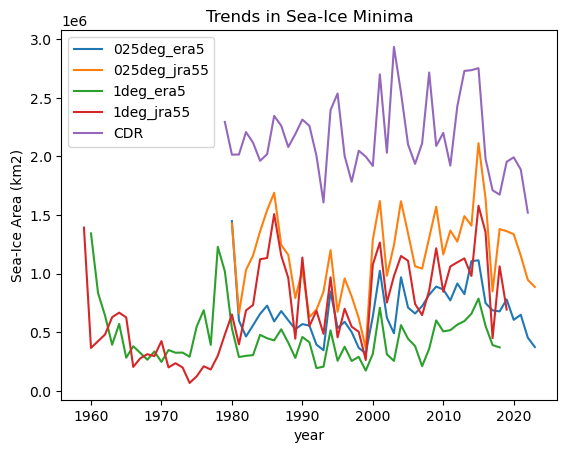

In [32]:
for iGroup in sia_min_max.groups[1:]:
    ds=sia_min_max[iGroup].ds
    ds['min'].plot(label=iGroup[1:])

obs_min=hist_area_dt['cdr_sh'].ds.cdr_area.groupby('time.year').min()

obs_min.plot(label='CDR')

plt.title('Trends in Sea-Ice Minima')
plt.ylabel('Sea-Ice Area (km2)')

plt.legend()

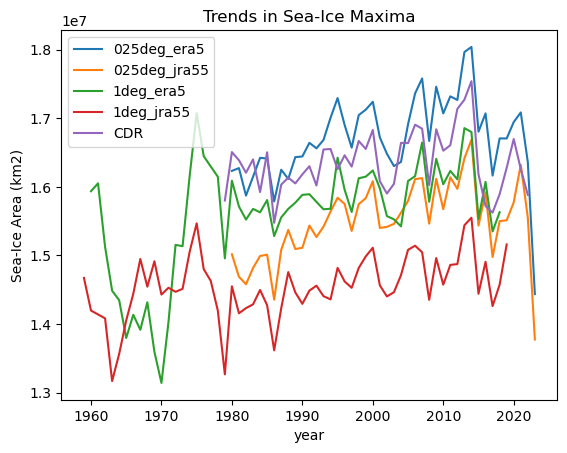

In [33]:
for iGroup in sia_min_max.groups[1:]:
    ds=sia_min_max[iGroup].ds
    ds['max'].plot(label=iGroup[1:])

hist_area_dt['cdr_sh'].ds.cdr_area.groupby('time.year').max().plot(label='CDR')

plt.title('Trends in Sea-Ice Maxima')
plt.ylabel('Sea-Ice Area (km2)')

plt.legend()

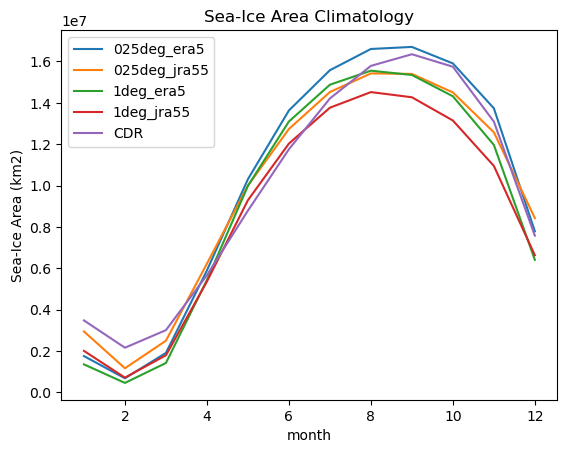

In [29]:
for iGroup in si_area_dt.groups[1:]:
    si_area_dt[iGroup].ds.si_area.groupby('time.month').mean('time').plot(label=iGroup[1:])

hist_area_dt['cdr_sh'].ds.cdr_area.groupby('time.month').mean('time').plot(label='CDR')

plt.title('Sea-Ice Area Climatology')
plt.ylabel('Sea-Ice Area (km2)')

plt.legend()

# Sea Ice Area Anomalies

In [35]:
@map_over_subtree
def area_anom(ds):
    return ds.groupby('time.month')-ds.sel(time=CLIMAT_SLICE).groupby('time.month').mean('time')

In [36]:
sh_anoms_dt=area_anom(si_area_dt)

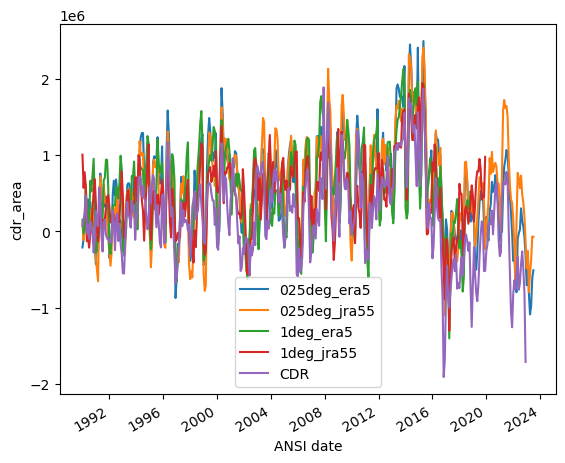

In [37]:
for iGroup in sia_min_max.groups[1:]:
    sh_anoms_dt[iGroup].ds.si_area.sel(time=slice('1990','2024')).plot(label=iGroup[1:])

(
    hist_area_dt['cdr_sh'].ds.cdr_area.groupby('time.month')
    -hist_area_dt['cdr_sh'].ds.cdr_area.sel(time=CLIMAT_SLICE).groupby('time.month').mean('time')
).sel(time=slice('1990','2024')).plot(label='CDR')

plt.legend()

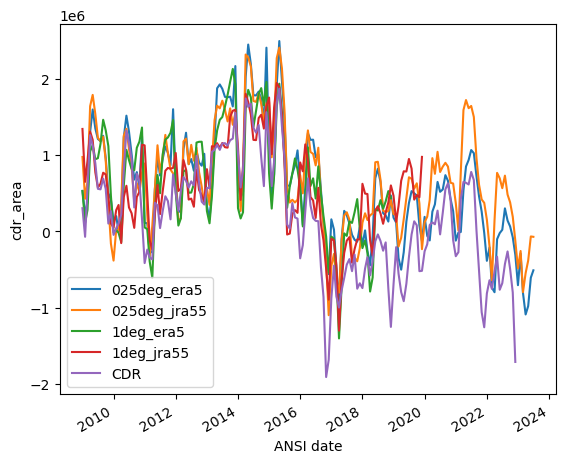

In [38]:
for iGroup in sh_anoms_dt.groups[1:]:
    sh_anoms_dt[iGroup].ds.si_area.sel(time=slice('2009','2024')).plot(label=iGroup[1:])

(
    hist_area_dt['cdr_sh'].ds.cdr_area.groupby('time.month')
    -hist_area_dt['cdr_sh'].ds.cdr_area.sel(time=CLIMAT_SLICE).groupby('time.month').mean('time')
).sel(time=slice('2009','2024')).plot(label='CDR')

plt.legend()

In [39]:
@map_over_subtree
def gridded_anoms(ds):
    
    climat=ds.sel(time=CLIMAT_SLICE).groupby('time.month').mean(['time'])
    anoms_xy=ds.groupby('time.month')-climat
    anoms_xy['area_t']=ds.area_t
    return anoms_xy

In [40]:
si_dt

DataTree('None', parent=None)
├── DataTree('025deg_era5')
│       Dimensions:   (time: 523, yt_ocean: 1080, xt_ocean: 1440)
│       Coordinates:
│         * time      (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2023-07-01
│         * xt_ocean  (xt_ocean) float64 -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
│         * yt_ocean  (yt_ocean) float64 -81.08 -80.97 -80.87 ... 89.74 89.84 89.95
│           geolat_t  (yt_ocean, xt_ocean) float32 ...
│           geolon_t  (yt_ocean, xt_ocean) float32 ...
│           area_t    (yt_ocean, xt_ocean) float32 nan nan nan nan ... nan nan nan nan
│       Data variables:
│           hs_m      (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
│           hi_m      (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
│           aice_m    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
│       Attributes: (12/16)
│           title:                                    sea ice model output for CICE
│           contents:                                 Diagnostic and Prognostic Varia...
│           source:                                   Los Alamos Sea Ice Model (CICE)...
│           time_period_freq:                         month_1
│           comment3:                                 seconds elapsed into model date...
│           conventions:                              CF-1.0
│           ...                                       ...
│           intake_esm_attrs:variable_long_name:      boundaries for time-averaging i...
│           intake_esm_attrs:variable_standard_name:  
│           intake_esm_attrs:variable_cell_methods:   time: mean,time: mean,time: mea...
│           intake_esm_attrs:file_id:                 iceh_XXXX_XX
│           intake_esm_attrs:_data_format_:           netcdf
│           intake_esm_dataset_key:                   iceh_XXXX_XX.1mon
├── DataTree('025deg_jra55')
│       Dimensions:   (time: 523, yt_ocean: 1080, xt_ocean: 1440)
│       Coordinates:
│         * time      (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2023-07-01
│         * xt_ocean  (xt_ocean) float64 -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
│         * yt_ocean  (yt_ocean) float64 -81.08 -80.97 -80.87 ... 89.74 89.84 89.95
│           geolat_t  (yt_ocean, xt_ocean) float32 ...
│           geolon_t  (yt_ocean, xt_ocean) float32 ...
│           area_t    (yt_ocean, xt_ocean) float32 nan nan nan nan ... nan nan nan nan
│       Data variables:
│           aice_m    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
│           hi_m      (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
│           hs_m      (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
│       Attributes: (12/16)
│           title:                                    sea ice model output for CICE
│           contents:                                 Diagnostic and Prognostic Varia...
│           source:                                   Los Alamos Sea Ice Model (CICE)...
│           time_period_freq:                         month_1
│           comment3:                                 seconds elapsed into model date...
│           conventions:                              CF-1.0
│           ...                                       ...
│           intake_esm_attrs:variable_long_name:      boundaries for time-averaging i...
│           intake_esm_attrs:variable_standard_name:  
│           intake_esm_attrs:variable_cell_methods:   time: mean,time: mean,time: mea...
│           intake_esm_attrs:file_id:                 iceh_XXXX_XX
│           intake_esm_attrs:_data_format_:           netcdf
│           intake_esm_dataset_key:                   iceh_XXXX_XX.1mon
├── DataTree('1deg_era5')
│       Dimensions:   (time: 708, yt_ocean: 300, xt_ocean: 360)
│       Coordinates:
│         * time      (time) d

In [41]:
si_xyanoms_dt=gridded_anoms(si_dt)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 44 times more chunks
  return self.array[key]
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 44 times more chunks
  return self.array[key]
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 59 times more chunks
  return self.array[key]
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 60 times more chunks
  return self.array[key]


# Sea Ice Conc Maps

In [42]:
def plot_si_conc(data, kwargs={}):
    """ A function for plotting tri-polar data"""
    ax = plt.gca()

    # Map the plot boundaries to a circle
    # theta = np.linspace(0, 2*np.pi, 100)
    # center, radius = [0.5, 0.5], 0.5
    # verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    # circle = mpath.Path(verts * radius + center)
    # ax.set_boundary(circle, transform=ax.transAxes)

    # Add land features and gridlines
    # ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='black',
    #                facecolor = 'gainsboro'), zorder = 2)

    # data.plot.contourf(
    plt.contourf(
        data.geolon_t,
        data.geolat_t,
        data,
        transform=ccrs.PlateCarree(),
        # x = 'geolon_t', 
        # y = 'geolat_t', 
        # levels = np.arange(0.15,1.05,.05),
        # cmap = cmo.balance,
        # cbar_kwargs = {
            # 'label':'Sea Ice Concentration'
        # },
        **kwargs
    )

    # gl = ax.gridlines(
    #     draw_labels=True, linewidth=1, color='gray', alpha=0.2, linestyle='--',
    #     ylocs=np.arange(-80,81,10)
    # )

    # ax.coastlines()

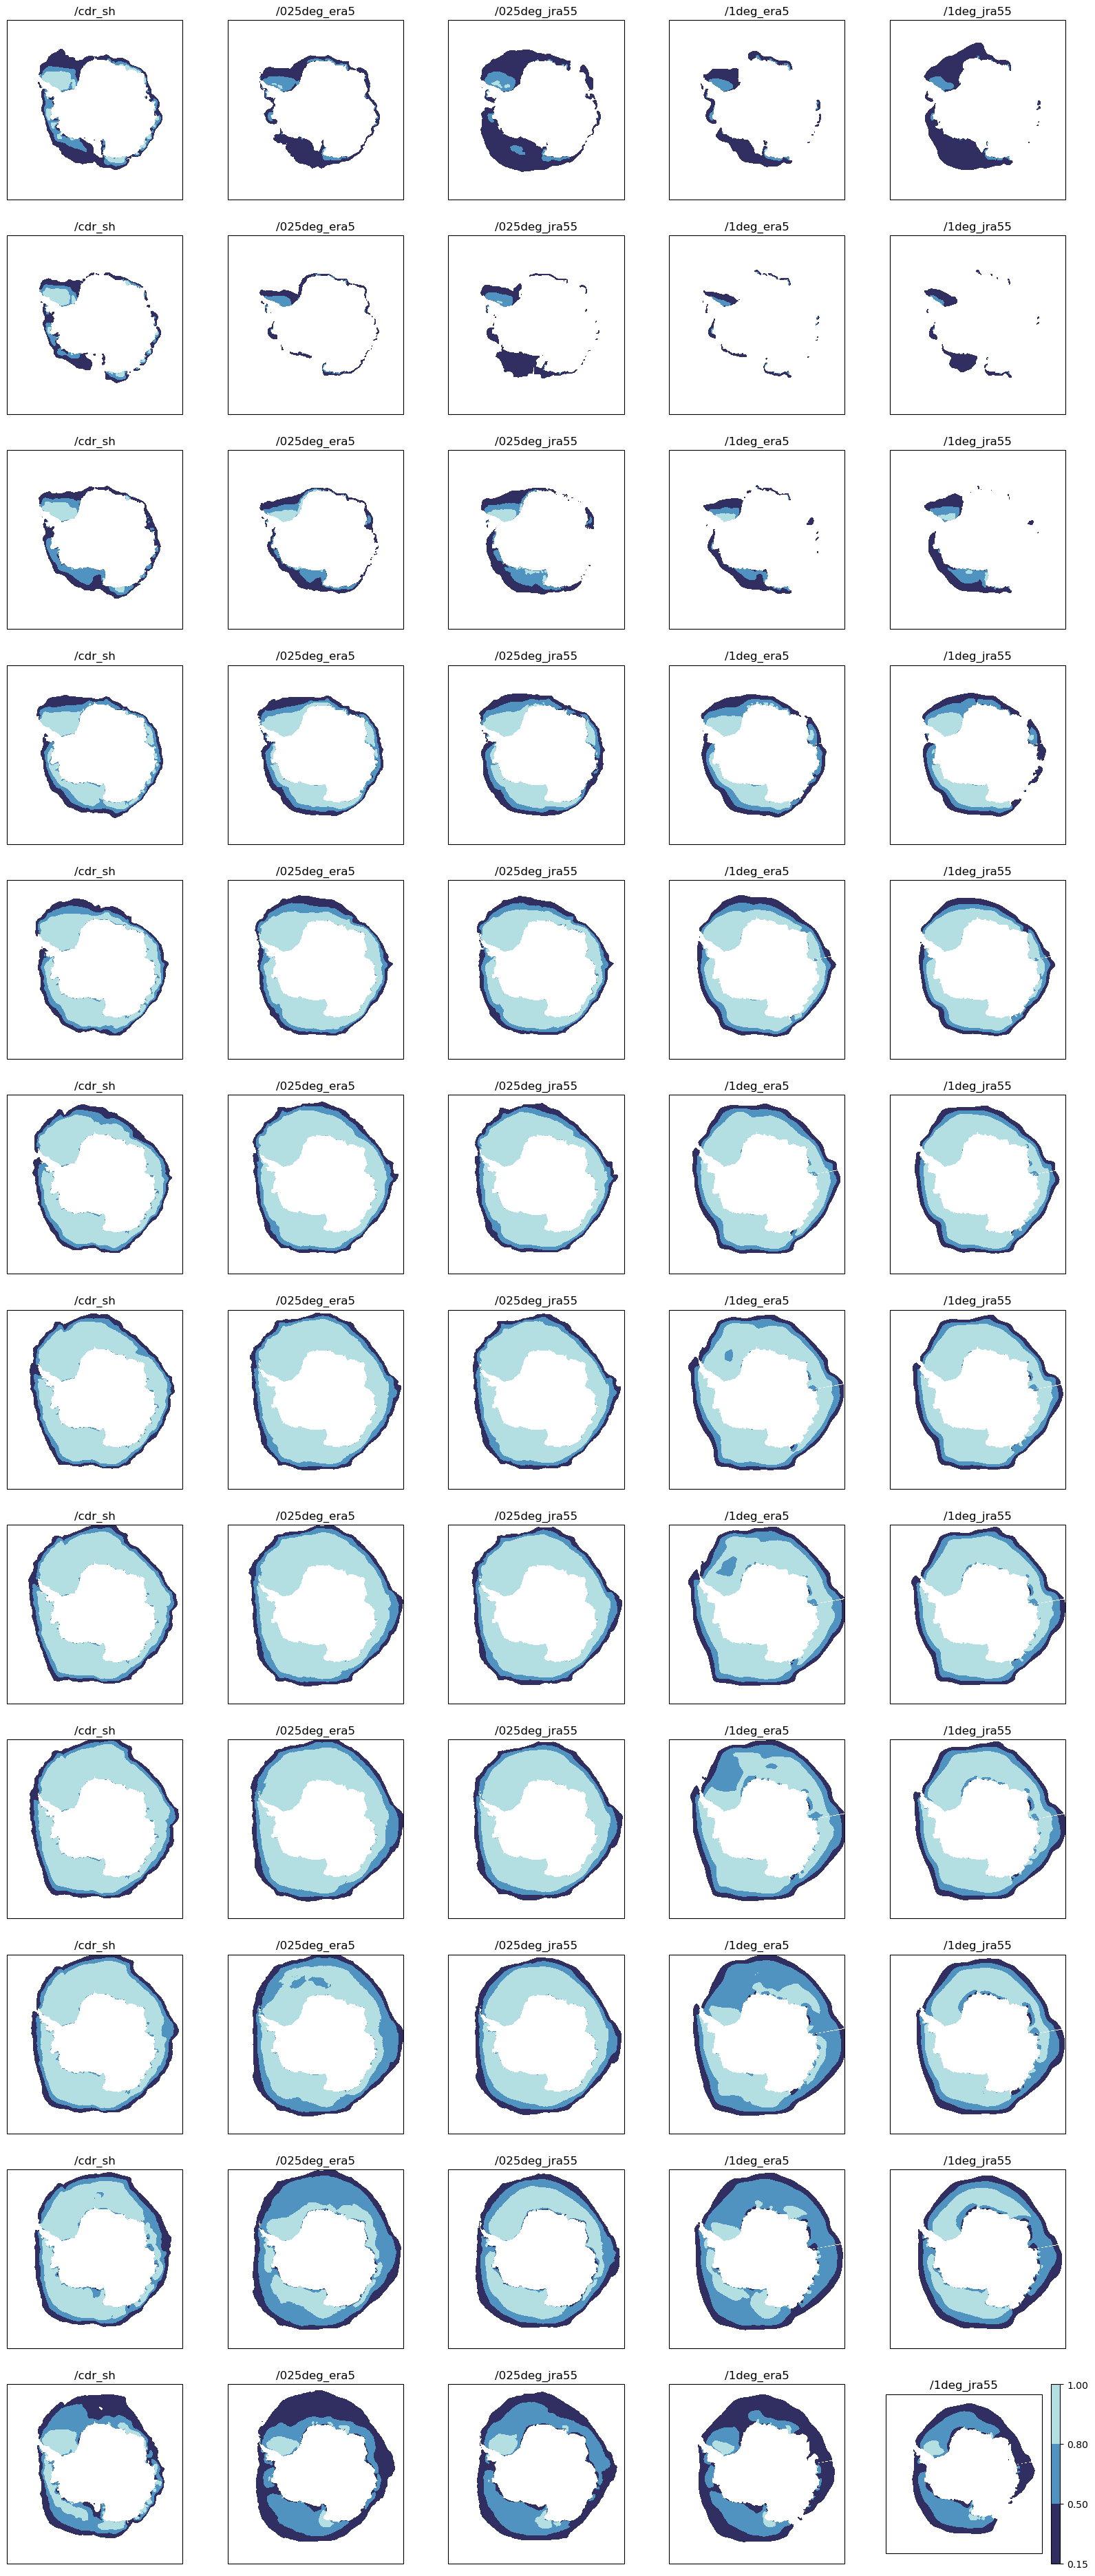

In [43]:
times=np.arange(1,13)

args={
                # 'levels':np.arange(0,1.06,.2),
                'levels':[0.15,0.5,0.8,1],
                'cmap':cmo.ice
           }

plt.figure(figsize=(20,48))
j=0

for iTime in times:

    i=1
    
    for iGroup in ['/cdr_sh']:
        ds=cdr_dt[iGroup].ds.cdr_seaice_conc
        
        ds=ds.sel(time=ds.time.dt.month.isin(iTime)).mean('time')
           
        ax = plt.subplot(12,5,i+j*5,projection=ccrs.SouthPolarStereo(true_scale_latitude=-70))

        # ax.set_ylabel(str(iTime.values)[0:7])
        
        ax.set_extent([-180, 180, -90, -55], crs=ccrs.PlateCarree())
    
        plt.contourf(
            ds.x, ds.y, ds,
            **args
        )
        
        plt.title(iGroup)
        
        i+=1

    
    
    for iGroup in si_dt.groups[1:]:
        ds=si_dt[iGroup].ds.aice_m
        
        ds=ds.sel(time=ds.time.dt.month.isin(iTime)).mean('time')
        
        ax = plt.subplot(12,5,i+j*5,projection=ccrs.SouthPolarStereo(true_scale_latitude=-70))
    
        ax.set_extent([-180, 180, -90, -55], crs=ccrs.PlateCarree())
        
        plot_si_conc(
            ds, 
            args
        )
    
        plt.title(iGroup)
        
        i+=1

    j+=1

plt.colorbar(fraction=0.1)

# Sea Ice Area differences

We need to regrid to comapre the datasets:

In [44]:
groups=si_dt.groups[1:]

In [45]:
#Lets simplify a little to only look at 0.25
groups=('/025deg_era5', '/025deg_jra55')

In [46]:
sps_ds=xr.open_dataset('/g/data/gv90/P6_data/NSIDC/G02202-cdr-ancillary-sh.nc')

In [47]:
regridder_ACCESSOM2_025deg_sh = xesmf.Regridder(
    si_dt['025deg_era5'].ds.isel(time=0).drop(['xt_ocean','yt_ocean']), 
    sps_ds, 
    'bilinear', 
    periodic=True,
    unmapped_to_nan=True,
    # filename="bilinear_tracer_weights_in1degACCESSOM2_out1deg.nc"
)

In [48]:
aice_sh_3976_ds=xr.Dataset()
aice_sh_diff_ds=xr.Dataset()

for iG in groups:
    aice_sh_3976_ds[iG]=regridder_ACCESSOM2_025deg_sh(
        si_dt[iG].ds.aice_m
    ).load()
    aice_sh_diff_ds[iG]=aice_sh_3976_ds[iG]-cdr_dt['cdr_sh'].ds.cdr_seaice_conc.load()

In [49]:
len(groups)

2

The 

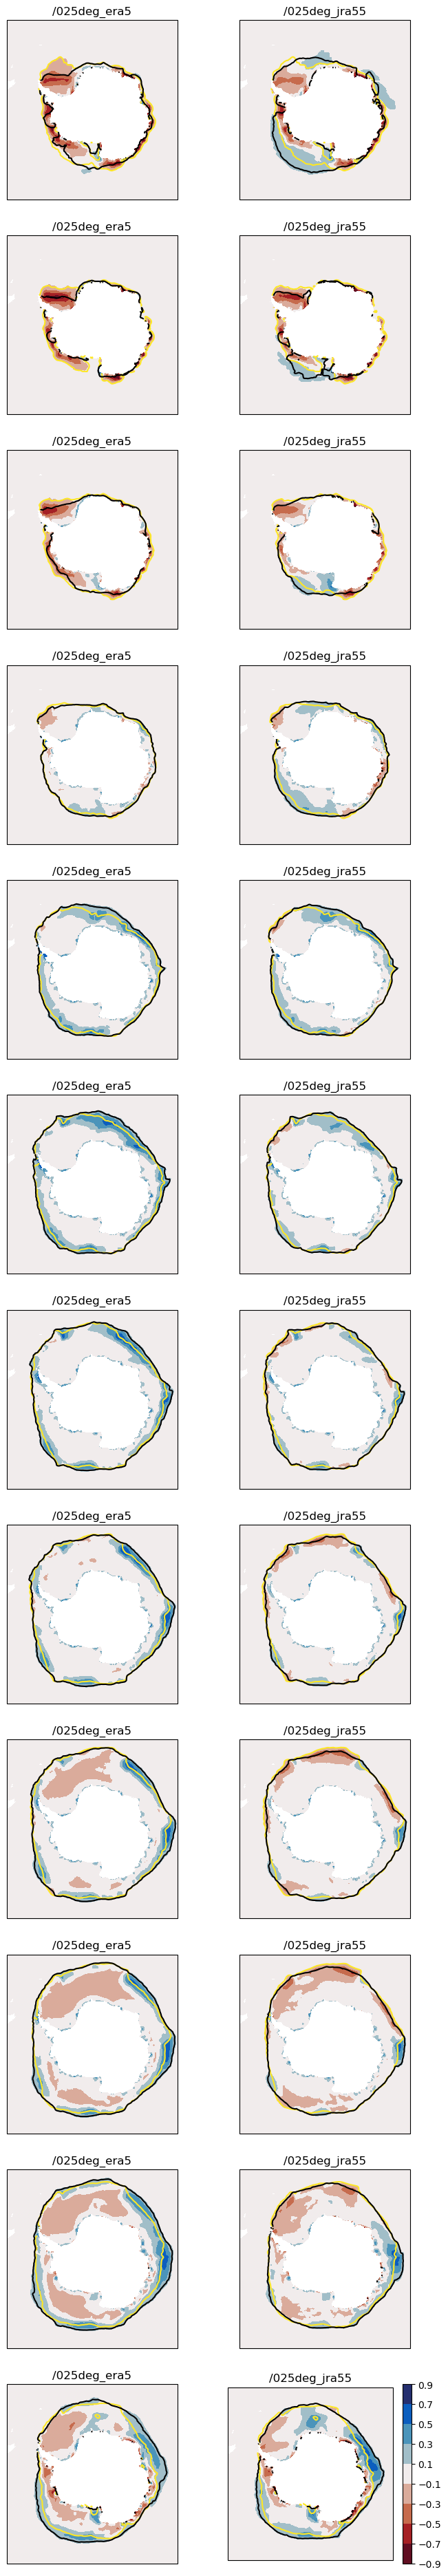

In [50]:
times=np.arange(1,13)

args={
    'levels':np.arange(-0.9,0.91,.2),
    'cmap':cmo.balance_r
}

plt.figure(figsize=(8,48))
j=0

cdr=cdr_dt['cdr_sh'].ds.cdr_seaice_conc


for iTime in times:

    i=1

    for iGroup in aice_sh_diff_ds.data_vars:
        ds=aice_sh_diff_ds[iGroup]
        
        ds=ds.sel(time=ds.time.dt.month.isin(iTime)).mean('time')
        
        ax = plt.subplot(12,2,i+j*2,projection=ccrs.SouthPolarStereo(true_scale_latitude=-70))
            
        plt.contourf(ds.x, ds.y, ds,**args)
                
        

        cdr.sel(time=cdr.time.dt.month.isin(iTime)).mean('time').plot.contour(levels=[0.15])
        
        da=aice_sh_3976_ds[iGroup]
        da.sel(time=da.time.dt.month.isin(iTime)).mean('time').plot.contour(levels=[0.15], colors=['black'])

        plt.title(iGroup)
        i+=1

    j+=1

plt.colorbar(fraction=0.1)

In [51]:
client.close()

2023-11-07 09:50:53,667 - distributed.nanny - WARNING - Worker process still alive after 3.1999986267089846 seconds, killing
2023-11-07 09:50:53,672 - distributed.nanny - WARNING - Worker process still alive after 3.1999992370605472 seconds, killing
2023-11-07 09:50:53,673 - distributed.nanny - WARNING - Worker process still alive after 3.199999389648438 seconds, killing
2023-11-07 09:50:53,674 - distributed.nanny - WARNING - Worker process still alive after 3.1999992370605472 seconds, killing
2023-11-07 09:50:53,676 - distributed.nanny - WARNING - Worker process still alive after 3.199999389648438 seconds, killing
2023-11-07 09:50:53,677 - distributed.nanny - WARNING - Worker process still alive after 3.199999389648438 seconds, killing
2023-11-07 09:50:53,679 - distributed.nanny - WARNING - Worker process still alive after 3.1999992370605472 seconds, killing
2023-11-07 09:50:53,680 - distributed.nanny - WARNING - Worker process still alive after 3.1999990844726565 seconds, killing
